In [110]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy              as np
import plotly.express       as px
import pydotplus         as pdp
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics          import mean_absolute_error, mean_squared_error
from IPython.display         import Image
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics          import accuracy_score, confusion_matrix
from sklearn.metrics          import auc,roc_curve
from sklearn.metrics          import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

### LOADING DATASET

In [ ]:
df3 = pd.read_csv('./data/paris_weekdays.csv')
df4 = pd.read_csv('./data/paris_weekends.csv')

In [112]:
df3['weekends'] = 0
df4['weekends'] = 1

In [113]:
d = [df3, df4]
df = pd.concat(d, axis= 0)
df = df.rename(columns= {df.columns[0]: 'ID'})
df.drop(['ID', 'attr_index_norm', 'rest_index_norm'], axis=1, inplace=True)
df

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,weekends
0,296.159940,Private room,False,True,2.0,True,0,0,10.0,97.0,1,0.699821,0.193709,518.478947,1218.662228,2.35385,48.86282,0
1,288.237487,Private room,False,True,2.0,True,0,0,10.0,97.0,1,2.100005,0.107221,873.216962,1000.543327,2.32436,48.85902,0
2,211.343089,Private room,False,True,2.0,False,0,0,10.0,94.0,1,3.302325,0.234724,444.556077,902.854467,2.31714,48.87475,0
3,298.956100,Entire home/apt,False,False,2.0,False,0,1,9.0,91.0,1,0.547567,0.195997,542.142014,1199.184166,2.35600,48.86100,0
4,247.926181,Entire home/apt,False,False,4.0,False,0,0,7.0,82.0,1,1.197921,0.103573,406.928958,1070.775497,2.35915,48.86648,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,295.460900,Entire home/apt,False,False,4.0,False,0,0,9.0,80.0,1,3.660389,0.168146,209.752453,540.326583,2.38051,48.88393,1
3554,232.081275,Entire home/apt,False,False,4.0,False,0,0,10.0,98.0,1,3.558813,0.154703,185.486701,474.351813,2.40050,48.85093,1
3555,223.925809,Entire home/apt,False,False,2.0,False,1,0,9.0,89.0,1,4.205205,0.253029,172.658919,406.585935,2.40100,48.87700,1
3556,200.857489,Entire home/apt,False,False,2.0,True,0,0,9.0,93.0,1,2.891214,0.240674,235.167925,602.451672,2.38200,48.87400,1


### PREPROCESSING

In [114]:
continuous_cols = ['realSum', 'guest_satisfaction_overall', 
                 'dist','metro_dist', 'attr_index','rest_index', 'lng', 'lat']
discrete_cols = ['person_capacity', 'cleanliness_rating', 'bedrooms' ]
binary_cols = ['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz', 'weekends']
nominal_cols = ['room_type']
num_cols = continuous_cols + discrete_cols

In [115]:
df_reg = df.copy()
df_reg.shape

(6688, 18)

#### Handling outliers

In [172]:
cols_to_winsorize_right = ['realSum', 'attr_index', 'metro_dist']
cols_to_winsorize_left = ['guest_satisfaction_overall']

for col in cols_to_winsorize_right:
    df_reg[col] = winsorize(df_reg[col], limits=[0, 0.05]).data

for col in cols_to_winsorize_left:
    df_reg[col] = winsorize(df_reg[col], limits=[0.05, 0]).data


#### Transforming data

In [117]:
df_reg['x'] = np.cos(np.radians(df_reg['lat'])) * np.cos(np.radians(df_reg['lng']))
df_reg['y'] = np.cos(np.radians(df_reg['lat'])) * np.sin(np.radians(df_reg['lng']))
df_reg['z'] = np.sin(np.radians(df_reg['lat']))

In [118]:
df_reg = df_reg.drop(['lng', 'lat'], axis= 1)

#### Handling skewness

In [ ]:
from scipy import stats

def auto_transform_skewed(df, numeric_cols, skew_threshold=0.5):
    """
    Detect and handle skewness
    - Box-Cox if skew > threshold and > 0
    - Yeo-Johnson if skew > threshold and <= 0
    - Power transform if skew < - threshold

    """
    transform_summary = {}

    for col in numeric_cols:
        skew = df_reg[col].skew()
        method = None

        if abs(skew) < skew_threshold:
            continue

        # right skew
        if skew > skew_threshold:
            if (df[col] > 0).all():
                df_reg[col], _ = stats.boxcox(df[col])
                method = 'Box-Cox'
            else:
                pt = PowerTransformer(method='yeo-johnson')
                df_reg[col] = pt.fit_transform(df[[col]])
                method = 'Yeo-Johnson'
            print(f"{col}: skew={skew:.2f}: right skew → dùng {method}")

        # left skew
        elif skew < -skew_threshold:
            # Power transform ngược lại (flip sign rồi transform)
            flipped = -df[col] + df[col].max() + 1
            pt = PowerTransformer(method='yeo-johnson')
            df_reg[col] = -pt.fit_transform(flipped.to_frame())
            method = 'Power transform (left skew)'
            print(f"{col}: skew={skew:.2f}: left skew → dùng {method}")

        transform_summary[col] = {'skew_before': skew, 'method': method}

    return df_reg, pd.DataFrame(transform_summary).T


In [121]:
numeric_cols = df_reg.select_dtypes(include = ['float64', 'int64'])
df_reg, summary = auto_transform_skewed(df_reg, numeric_cols)

realSum: skew=1.05: right skew → dùng Box-Cox
person_capacity: skew=0.99: right skew → dùng Box-Cox
multi: skew=1.36: right skew → dùng Yeo-Johnson
biz: skew=1.18: right skew → dùng Yeo-Johnson
cleanliness_rating: skew=-2.25: left skew → dùng Power transform (left skew)
guest_satisfaction_overall: skew=-0.75: left skew → dùng Power transform (left skew)
bedrooms: skew=0.67: right skew → dùng Yeo-Johnson
attr_index: skew=0.65: right skew → dùng Box-Cox


In [122]:
def count_extreme_outliers(df, cols):
    extreme_counts = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3*IQR
        upper = Q3 + 3*IQR
        count = ((df[col] < lower) | (df[col] > upper)).sum()
        extreme_counts[col] = count
    return extreme_counts

# Giả sử các cột numeric sau Box-Cox/Yeo-Johnson
numeric_cols = ['metro_dist', 'attr_index', 'rest_index', 'realSum', 'guest_satisfaction_overall']
extreme_counts = count_extreme_outliers(df_reg, numeric_cols)
extreme_counts

{'metro_dist': np.int64(0),
 'attr_index': np.int64(0),
 'rest_index': np.int64(0),
 'realSum': np.int64(0),
 'guest_satisfaction_overall': np.int64(0)}

In [123]:
encoder_1 = LabelEncoder()
df_reg['room_type'] =  encoder_1.fit_transform(df_reg['room_type'])

map = {'True': 1, 'False' : 0}
cols = ['room_shared', 'room_private']
df_reg[cols] = df_reg[cols].replace(map)

### UNIVARIATE TREE

In [124]:
X = df_reg.drop('realSum', axis=1, inplace=False)
y = df_reg['realSum']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=81)

#### Training with Default Hyperparameters

In [126]:
reg = DecisionTreeRegressor(criterion='squared_error')
reg_model = reg.fit(X_train, y_train)

In [127]:
def regression_eval(y_test, y_pred):
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    return mae, mse

In [128]:
y_pred = reg_model.predict(X_test)
errors   = regression_eval(y_test, y_pred)
r2_total = reg_model.score(X, y)
r2_train = reg_model.score(pd.DataFrame(X_train), y_train)
r2_test  = reg_model.score(pd.DataFrame(X_test),  y_test)

## Hiển thị giá trị các chỉ số
print(f'MAE = {errors[0]:.1f}%')
print(f'MSE = {errors[1]:.1f}%')
print(f'Mô hình giải thích được {(r2_total * 100):.1f}% toàn bộ dữ liệu')
print(f'Mô hình giải thích được {(r2_train * 100):.1f}% training set')
print(f'Mô hình  giải thích được {(r2_test  * 100):.1f}% test set')

MAE = 0.1%
MSE = 0.0%
Mô hình giải thích được 93.4% toàn bộ dữ liệu
Mô hình giải thích được 100.0% training set
Mô hình  giải thích được 67.4% test set


#### Tuning Hyperparameters and Comparing

In [129]:
from sklearn.metrics import r2_score

params = []
acc = []

for i in range(1, 11):
    model = DecisionTreeRegressor()
    param_distributions = {
    'criterion': ['squared_error'],  
    'splitter': ['best'],           
    'max_depth': [i for i in range(20, 50, 5)],  
    'min_samples_split': [i for i in range(2, 16, 2)],         
    'min_samples_leaf': [i for i in range(2, 10, 2)],            
    'max_features': [None, 'sqrt', 'log2'],             
    'max_leaf_nodes': [i for i in range(150, 180, 5)],      
    'ccp_alpha': [0.0, 0.001, 0.002, 0.005]             
    }


    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=1000,            
        scoring='r2',
        cv=5,
        verbose=2,
        random_state=81,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    params.append(random_search.best_params_)

    best_model = random_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    test_r2 = r2_score(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse  = mean_squared_error(y_test, y_pred_test)

    acc.append({
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse
    })
    
params_df = pd.DataFrame(params)
acc_df = pd.DataFrame(acc)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [130]:
r = [params_df, acc_df]
result_df_random = pd.concat(r, axis= 1)
result_df_random['test_train_diff'] = result_df_random['train_r2'] - result_df_random['test_r2']
result_df_random

,splitter,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,criterion,ccp_alpha,train_r2,test_r2,train_mse,test_mse,test_train_diff
0,best,6,4,170,None,20,squared_error,0.0,0.731636,0.644390,0.012195,0.016527,0.087247
1,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
2,best,8,4,170,None,20,squared_error,0.0,0.731636,0.644390,0.012195,0.016527,0.087247
3,best,10,4,170,None,25,squared_error,0.0,0.731122,0.648145,0.012218,0.016353,0.082977
4,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
5,best,10,4,170,None,25,squared_error,0.0,0.731122,0.648145,0.012218,0.016353,0.082977
6,best,8,6,175,None,30,squared_error,0.0,0.729900,0.639110,0.012273,0.016772,0.090790
7,best,2,6,175,None,45,squared_error,0.0,0.729900,0.639110,0.012273,0.016772,0.090790
8,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
9,best,2,4,175,None,45,squared_error,0.0,0.735534,0.647634,0.012017,0.016376,0.087900


In [131]:
result_df_random_ = result_df_random.loc[result_df_random['test_r2'] >= 0.645, :]
result_df_random_

,splitter,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,criterion,ccp_alpha,train_r2,test_r2,train_mse,test_mse,test_train_diff
1,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
3,best,10,4,170,None,25,squared_error,0.0,0.731122,0.648145,0.012218,0.016353,0.082977
4,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
5,best,10,4,170,None,25,squared_error,0.0,0.731122,0.648145,0.012218,0.016353,0.082977
8,best,8,4,170,None,20,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095
9,best,2,4,175,None,45,squared_error,0.0,0.735534,0.647634,0.012017,0.016376,0.087900


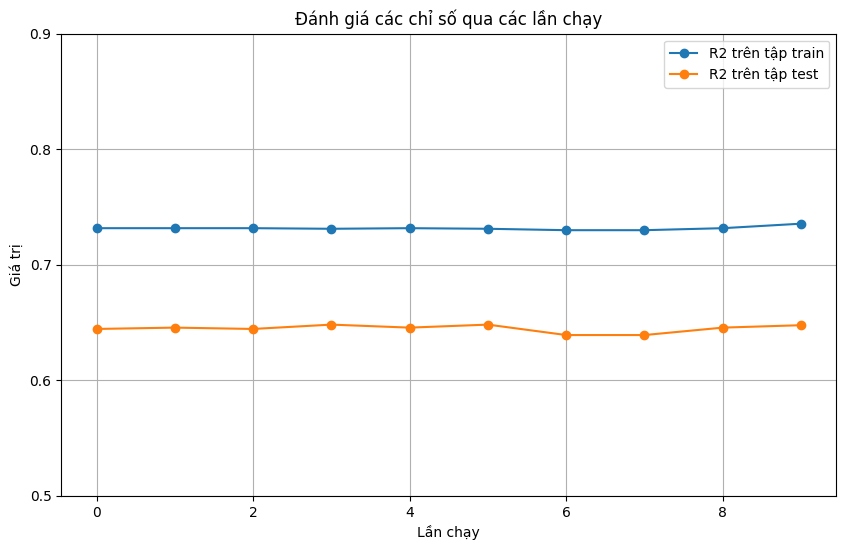

In [132]:
plt.figure(figsize=(10,6))
plt.plot(result_df_random.index, result_df_random['train_r2'], label='R2 trên tập train', marker= 'o')
plt.plot(result_df_random.index, result_df_random['test_r2'], label='R2 trên tập test', marker='o')

"""plt.plot(results_df['depth'], results_df['precision'], label='Precision')
plt.plot(results_df['depth'], results_df['recall'], label='Recall')
plt.plot(results_df['depth'], results_df['f1'], label='F1-score')"""

plt.xlabel('Lần chạy')
plt.ylabel('Giá trị')
plt.yticks(np.arange(0.5, 1, 0.1))
plt.title('Đánh giá các chỉ số qua các lần chạy')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

params = []
acc = []

for i in range(1, 2):
    model = DecisionTreeRegressor()

    param_grid = {
        'criterion': ['squared_error'],
        'splitter': ['best'],
        'max_depth': [i for i in range(20, 26, 1)],
        'min_samples_split': [i for i in range(6, 11, 2)],
        'min_samples_leaf': [4],
        'max_features': [None],
        'max_leaf_nodes': [170],
        'ccp_alpha': [0.0]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    params.append(grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    test_r2 = r2_score(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse  = mean_squared_error(y_test, y_pred_test)

    acc.append({
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse
    })

params_df = pd.DataFrame(params)
acc_df = pd.DataFrame(acc)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [168]:
r = [params_df, acc_df]
result_df = pd.concat(r, axis= 1)
result_df['test_train_diff'] = result_df['train_r2'] - result_df['test_r2']
result_df

,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,splitter,train_r2,test_r2,train_mse,test_mse,test_train_diff
0,0.0,squared_error,23,None,170,4,8,best,0.731636,0.645542,0.012195,0.016474,0.086095


In [135]:

mse_df = pd.DataFrame({
    'Loại': ['Train', 'Train', 'Test', 'Test'],
    'Tổ hợp': ['Tổ hợp 1', 'Tổ hợp 2', 'Tổ hợp 1', 'Tổ hợp 2'],
    'Giá trị': [0.0122, 0.0121, 0.0163, 0.0165]
})

mse_df

,Loại,Tổ hợp,Giá trị
0,Train,Tổ hợp 1,0.0122
1,Train,Tổ hợp 2,0.0121
2,Test,Tổ hợp 1,0.0163
3,Test,Tổ hợp 2,0.0165


In [136]:

r_df = pd.DataFrame({
    'Loại': ['Train', 'Train', 'Test', 'Test'],
    'Tổ hợp': ['Tổ hợp 1', 'Tổ hợp 2', 'Tổ hợp 1', 'Tổ hợp 2'],
    'Giá trị': [0.7311, 0.7312, 0.6493, 0.6455]
})

r_df

,Loại,Tổ hợp,Giá trị
0,Train,Tổ hợp 1,0.7311
1,Train,Tổ hợp 2,0.7312
2,Test,Tổ hợp 1,0.6493
3,Test,Tổ hợp 2,0.6455


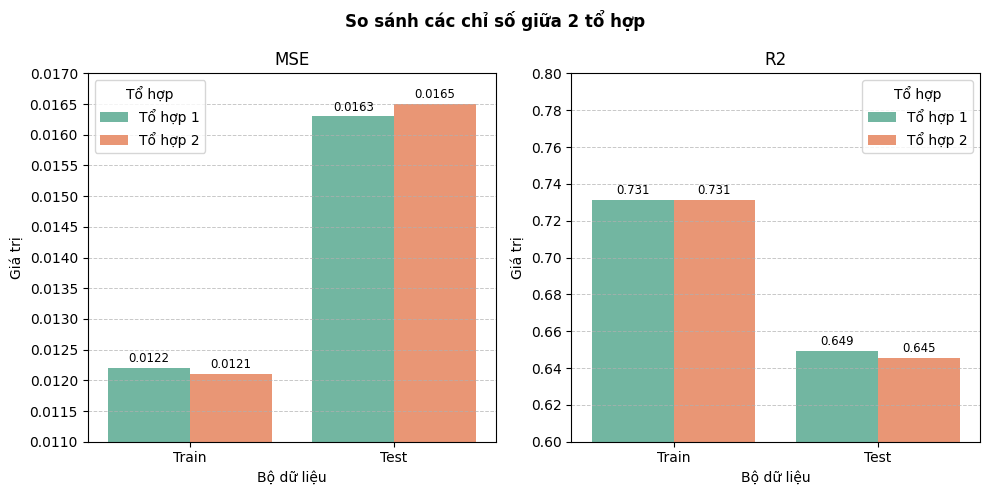

In [171]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=mse_df, x='Loại', y='Giá trị', hue='Tổ hợp', palette='Set2', ax=axes[0])
axes[0].set_title('MSE')
axes[0].set_xlabel('Bộ dữ liệu')
axes[0].set_ylim(0.011, 0.017) 
axes[0].yaxis.set_major_locator(MultipleLocator(0.0005))
axes[0].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axes[0].grid(True, which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.4f}", 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha='center', va='bottom', fontsize=8.5, color='black', xytext=(0, 2),
                     textcoords='offset points')

sns.barplot(data=r_df, x='Loại', y='Giá trị', hue='Tổ hợp',palette='Set2', ax=axes[1])
axes[1].set_title('R2')
axes[1].set_xlabel('Bộ dữ liệu')
axes[1].set_ylim(0.6, 0.8) 
axes[1].yaxis.set_major_locator(MultipleLocator(0.02))
axes[1].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axes[1].grid(True, which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.3f}", 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha='center', va='bottom', fontsize=8.5, color='black', xytext=(0, 2),
                     textcoords='offset points')

plt.suptitle('So sánh các chỉ số giữa 2 tổ hợp', weight='bold')
plt.tight_layout()
plt.show()



(process:24256): Pango-CRITICAL **: 14:19:57.842: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:24256): Pango-CRITICAL **: 14:19:57.842: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:24256): Pango-CRITICAL **: 14:19:57.842: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:24256): Pango-CRITICAL **: 14:19:57.842: pango_font_description_get_family: assertion 'desc != NULL' failed



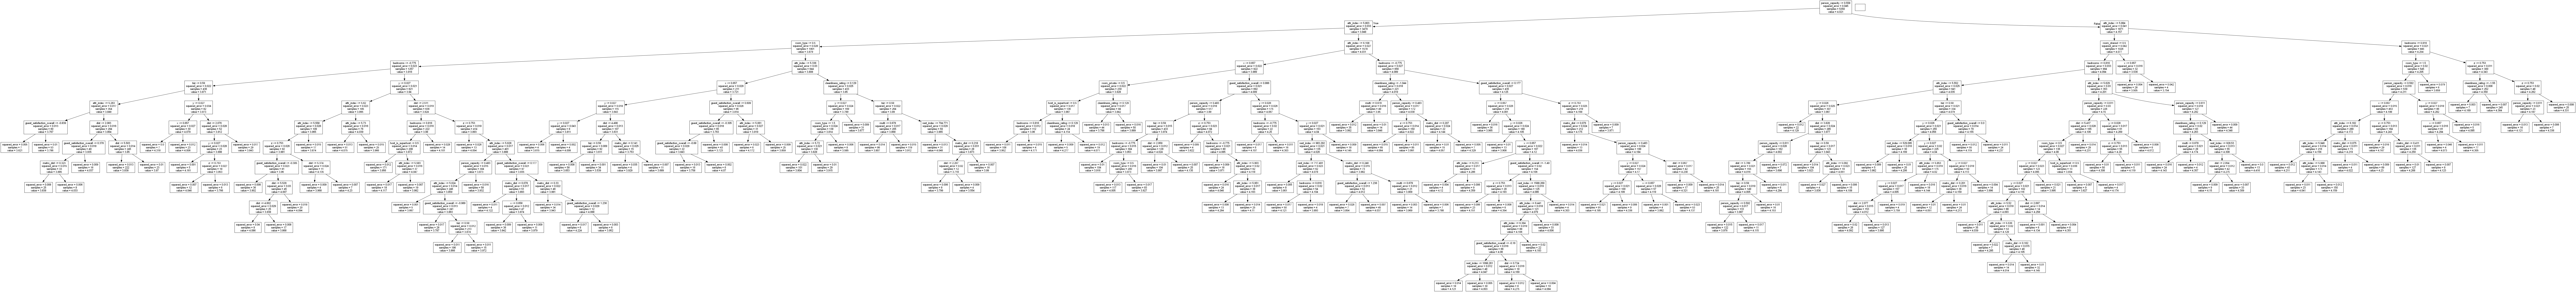

In [138]:
model = DecisionTreeRegressor(ccp_alpha=0, criterion='squared_error', max_depth=20, max_features=None, max_leaf_nodes= 170, min_samples_leaf=4, min_samples_split=6, splitter= 'best' )
model.fit(X_train, y_train)
dcs_tree = tree.export_graphviz(model, out_file = None, feature_names = X.columns)
graph = pdp.graph_from_dot_data(dcs_tree)
Image(graph.create_png())

In [139]:
# Xuất file ảnh
graph.write_png("Output/DecisionTree_Reg.png")
graph.write_pdf("Output/DecisionTree_Reg.pdf")

# Xuất file .dot hoặc .txt nếu muốn
with open("Output/DecisionTree_Reg.txt", "w") as f:
    f.write(dcs_tree)

print("Đã xuất: .png, .pdf, .txt")


(process:25064): Pango-CRITICAL **: 14:20:01.001: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:25064): Pango-CRITICAL **: 14:20:01.001: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:25064): Pango-CRITICAL **: 14:20:01.001: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:25064): Pango-CRITICAL **: 14:20:01.001: pango_font_description_get_family: assertion 'desc != NULL' failed


(process:13076): Pango-CRITICAL **: 14:20:03.023: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13076): Pango-CRITICAL **: 14:20:03.023: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13076): Pango-CRITICAL **: 14:20:03.023: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13076): Pango-CRITICAL **: 14:20:03.023: pango_font_description_get_family: assertion 'desc != NULL' failed

Đã xuất: .png, .pdf, .txt


#### Feature Importance

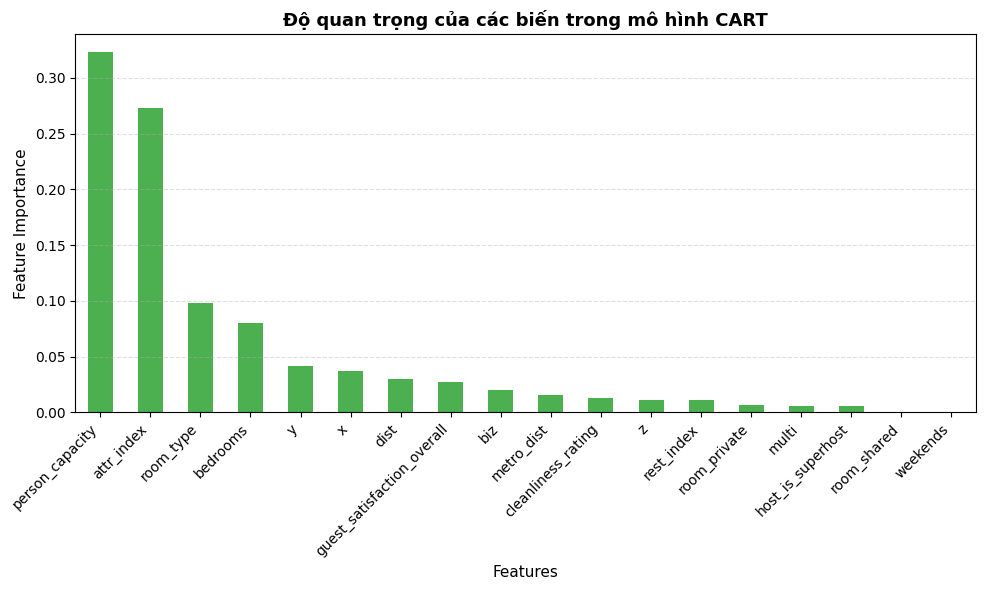

In [140]:
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6), color = '#4CAF50')

plt.title('Độ quan trọng của các biến trong mô hình CART', fontsize=13, fontweight='bold')
plt.xlabel('Features', fontsize=11)
plt.ylabel('Feature Importance', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### MULTIVARIATE TREE                                                                                               

In [141]:
df2 = df_reg.copy()

In [142]:
scaler = StandardScaler()
df2 = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2, columns = df_reg.columns)

In [143]:
continuous_cols = ['realSum', 'guest_satisfaction_overall',
                 'dist','metro_dist', 'attr_index','rest_index', 'x', 'y', 'z']
discrete_cols = ['person_capacity', 'cleanliness_rating', 'bedrooms' ]
binary_cols = ['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz']
nominal_cols = ['room_type', 'city']

#### Feature Combination

<Axes: >

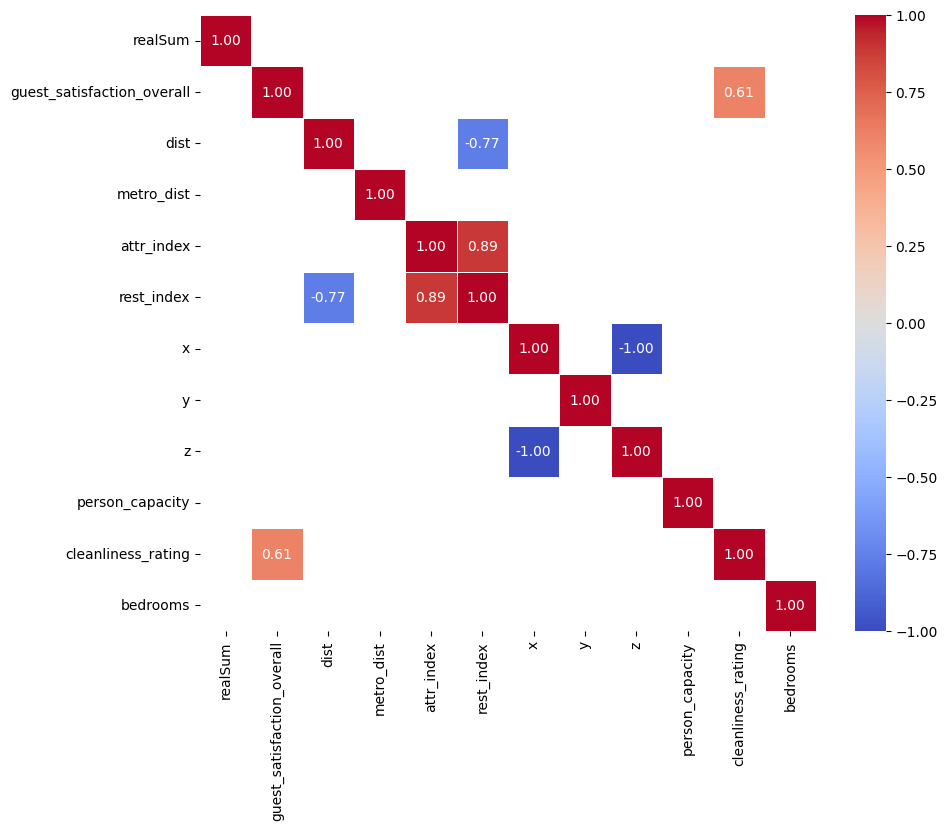

In [144]:
# num_mtrx.sort_values(ascending = True)
num_cols = continuous_cols + discrete_cols
num_mtrx = df2[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    num_mtrx[abs(num_mtrx) > 0.6],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

In [145]:
# Nhóm biến đi cùng nhau
pair_1 = ['rest_index', 'attr_index', 'dist']
pair_2 = ['cleanliness_rating', 'guest_satisfaction_overall']

In [ ]:
# --- 1: Assign weights based on correlation
def get_corr_weights(df, features, target):
    corr = df[features + [target]].corr()[target].abs()
    corr = corr.drop(target)
    weights = corr / corr.sum()
    return weights.to_dict()

# --- 2: Assign weights based on feature importance ---
def get_tree_weights(df, features, target):
    X = df[features]
    y = df[target]
    tree = DecisionTreeRegressor(max_depth=5, random_state=42)
    tree.fit(X, y)
    imp = tree.feature_importances_
    weights = imp / imp.sum()
    return dict(zip(features, weights))

# --- 3: Assign weights based on OLS ---
def get_ols_weights(df, features, target):
    X = df[features]
    y = df[target]
    model = LinearRegression().fit(X, y)
    coef = np.abs(model.coef_)
    weights = coef / coef.sum()
    return dict(zip(features, weights))


available_methods = ['corr', 'tree', 'ols']
method_choice = input(f"Nhập phương pháp ({', '.join(available_methods)}): ").strip().lower()

if method_choice == 'corr':
    weights_1 = get_corr_weights(df2, pair_1, 'realSum')
    weights_2 = get_corr_weights(df2, pair_2, 'realSum')
elif method_choice == 'tree':
    weights_1 = get_tree_weights(df2, pair_1, 'realSum')
    weights_2 = get_tree_weights(df2, pair_2, 'realSum')
elif method_choice == 'ols':
    weights_1 = get_ols_weights(df2, pair_1, 'realSum')
    weights_2 = get_ols_weights(df2, pair_2, 'realSum')
else:
    raise ValueError(f"Phương pháp không hợp lệ. Vui lòng chọn một trong {available_methods}.")

df2['location_score'] = (
    weights_1['rest_index'] * df2['rest_index'] +
    weights_1['attr_index'] * df2['attr_index'] -
    weights_1['dist'] * df2['dist'] 
)

df2['quality_score'] = (
    weights_2['cleanliness_rating'] * df2['cleanliness_rating'] +
    weights_2['guest_satisfaction_overall'] * df2['guest_satisfaction_overall']
)

df2.drop(columns=pair_1 + pair_2, inplace=True)

print(df2[['location_score', 'quality_score']].head())

   location_score  quality_score
0        1.308653       0.735093
1        1.138872       0.735093
2        0.363655       0.462744
3        1.356328      -0.610235
4        0.770582      -1.555666


In [147]:
X2 = df2.drop('realSum', axis=1, inplace=False)
y2 = df2['realSum']

In [148]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=81)

In [149]:
model2 = DecisionTreeRegressor()
model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_test2)

In [ ]:
def regression_eval(y_test, y_pred):
    mae  = mean_absolute_error(y_test2, y_pred2)
    mse  = mean_squared_error(y_pred2, y_test2)
    return mae, mse

errors   = regression_eval(y2, y_pred2)
r2_total = model2.score(X2, y2)
r2_train = model2.score(X_train2, y_train2)
r2_test  = model2.score(X_test2,  y_test2)

print(f'MAE = {errors[0]:.1f}')
print(f'MSE = {errors[1]:.1f}')
print(f'R2_Total giải thích được {(r2_total * 100):.1f}% toàn bộ dữ liệu')
print(f'R2_Train giải thích được {(r2_train * 100):.1f}% training set')
print(f'R2_Test  giải thích được {(r2_test  * 100):.1f}% test set')


MAE = 0.3
MSE = 0.3
R2_Total giải thích được 94.5% toàn bộ dữ liệu
R2_Train giải thích được 100.0% training set
R2_Test  giải thích được 72.8% test set


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


# --- 1. Random Search 
param_grid = {
     'criterion': ['squared_error'],
    'splitter': ['best'],
    'max_depth': [i for i in range(15, 50, 5)],
    'min_samples_split': [i for i in range(2, 16, 2)],
    'min_samples_leaf': [i for i in range(2, 10, 2)],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [i for i in range(150, 180, 5)],
    'ccp_alpha': [0.0, 0.001, 0.002, 0.005]
}

params, acc = [], []

for i in range(3):
    model = DecisionTreeRegressor(random_state=i)

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=80,
        scoring='r2',
        cv=5,
        verbose=1,
        random_state=81 + i,
        n_jobs=-1
    )

    random_search.fit(X_train2, y_train2)
    best_model = random_search.best_estimator_

    y_pred_train2 = best_model.predict(X_train2)
    y_pred_test2  = best_model.predict(X_test2)

    params.append(random_search.best_params_)
    acc.append({
        'train_r2': r2_score(y_train2, y_pred_train2),
        'test_r2':  r2_score(y_test2, y_pred_test2),
        'train_mse': mean_squared_error(y_train2, y_pred_train2),
        'test_mse':  mean_squared_error(y_test2, y_pred_test2)
    })

params_df = pd.DataFrame(params)
acc_df = pd.DataFrame(acc)
print("\nTop params từ Random Search:")
display(params_df)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Top params từ Random Search:


,splitter,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,criterion,ccp_alpha
0,best,2,2,175,None,30,squared_error,0.001
1,best,12,2,170,None,35,squared_error,0.001
2,best,6,2,175,None,15,squared_error,0.000


In [152]:
r = [params_df, acc_df]
result_df = pd.concat(r, axis= 1)
result_df['test_train_diff'] = result_df['train_r2'] - result_df['test_r2']
result_df

,splitter,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,criterion,ccp_alpha,train_r2,test_r2,train_mse,test_mse,test_train_diff
0,best,2,2,175,None,30,squared_error,0.001,0.675338,0.612139,0.323113,0.394803,0.063199
1,best,12,2,170,None,35,squared_error,0.001,0.675338,0.612139,0.323113,0.394803,0.063199
2,best,6,2,175,None,15,squared_error,0.000,0.730955,0.630223,0.267762,0.376394,0.100732


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd

# --- Grid Search (after narrowing down promising hyperparameters) ---
param_grid = {
        'criterion': ['squared_error'],
        'splitter': ['best'],
        'max_depth': [16],
        'min_samples_split': [6, 10],
        'min_samples_leaf': [4],
        'max_features': [None],
        'max_leaf_nodes': [170],
        'ccp_alpha': [0.0]
    }


grid = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --- Best model ---
best_model = grid.best_estimator_

# --- Prediction ---
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

# --- Efficiency ---
train_r2  = r2_score(y_train, y_pred_train)
test_r2   = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse  = mean_squared_error(y_test, y_pred_test)
mae       = mean_absolute_error(y_test, y_pred_test)
diff      = train_r2 - test_r2

# --- Results---
bestgrid_df = pd.DataFrame([{
    'splitter': grid.best_params_['splitter'],
    'min_samples_split': grid.best_params_['min_samples_split'],
    'min_samples_leaf': grid.best_params_['min_samples_leaf'],
    'max_leaf_nodes': grid.best_params_['max_leaf_nodes'],
    'max_features': grid.best_params_['max_features'],
    'max_depth': grid.best_params_['max_depth'],
    'criterion': grid.best_params_['criterion'],
    'ccp_alpha': grid.best_params_['ccp_alpha'],
    'train_r2': train_r2,
    'test_r2': test_r2,
    'train_mse': train_mse,
    'test_mse': test_mse,
    'test_train_diff': diff
}])


Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [154]:
print("\nModel Performance:")
display(bestgrid_df)


Model Performance:


,splitter,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,criterion,ccp_alpha,train_r2,test_r2,train_mse,test_mse,test_train_diff
0,best,6,4,170,None,16,squared_error,0.0,0.731636,0.645542,0.012195,0.016474,0.086095


In [155]:
data = {
    'Phương pháp': [
        'Tương quan',
        'Features Importance',
        'OLS',
        'Cây đơn biến'
    ],
    'R² tối ưu (Best Grid)': [64.5, 64.6, 64.6, 64.9],
    'R² tổ hợp (Random)': [63.7, 63.2, 63.0, 64.5],
    'Chênh lệch train-test': [8.6, 8.6, 8.6, 8],
    'Độ sâu tối ưu (max_depth)': [14, 14, 14, 20]
}

df = pd.DataFrame(data)

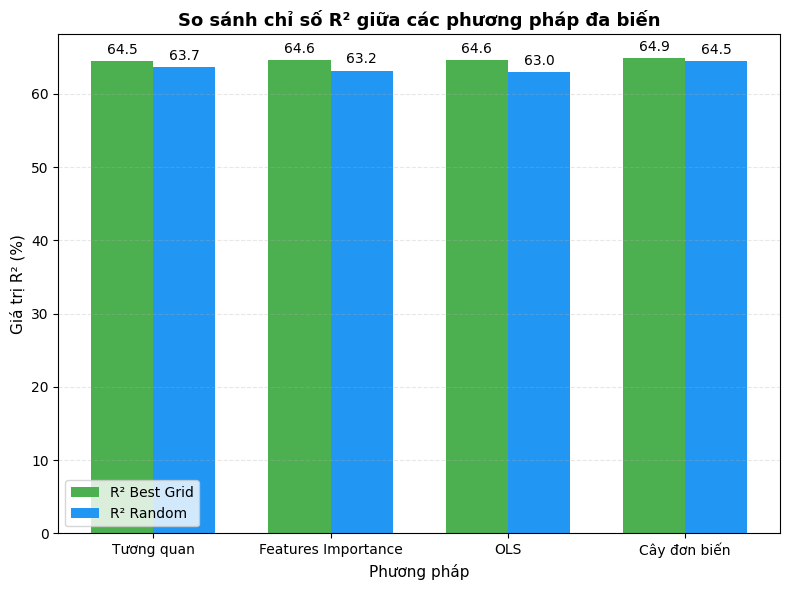

In [ ]:
x = np.arange(len(df['Phương pháp']))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

bar1 = ax.bar(x - width/2, df['R² tối ưu (Best Grid)'], width, label='R² Best Grid', color='#4CAF50')
bar2 = ax.bar(x + width/2, df['R² tổ hợp (Random)'], width, label='R² Random', color='#2196F3')

ax.set_title('So sánh chỉ số R² giữa các phương pháp đa biến', fontsize=13, fontweight='bold')
ax.set_xlabel('Phương pháp', fontsize=11)
ax.set_ylabel('Giá trị R² (%)', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(df['Phương pháp'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

for bars in [bar1, bar2]:
    ax.bar_label(bars, fmt='%.1f', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

In [157]:
data2 = {
    'R² tối ưu (Best Grid)': [63, 64.4, 64.5,64.5,64.5,64.5,64.5, 64.5, 64.5,64.5, 64.5],
    'Chênh lệch train-test': [8.8, 8.6, 8.6, 8.6,8.6,8.6, 8.6, 8.6, 8.6, 8.6, 8.6],
    'max_depth' : [10,13,14,15,16,17,18,19,20,25,30]
}
df2 = pd.DataFrame(data2)

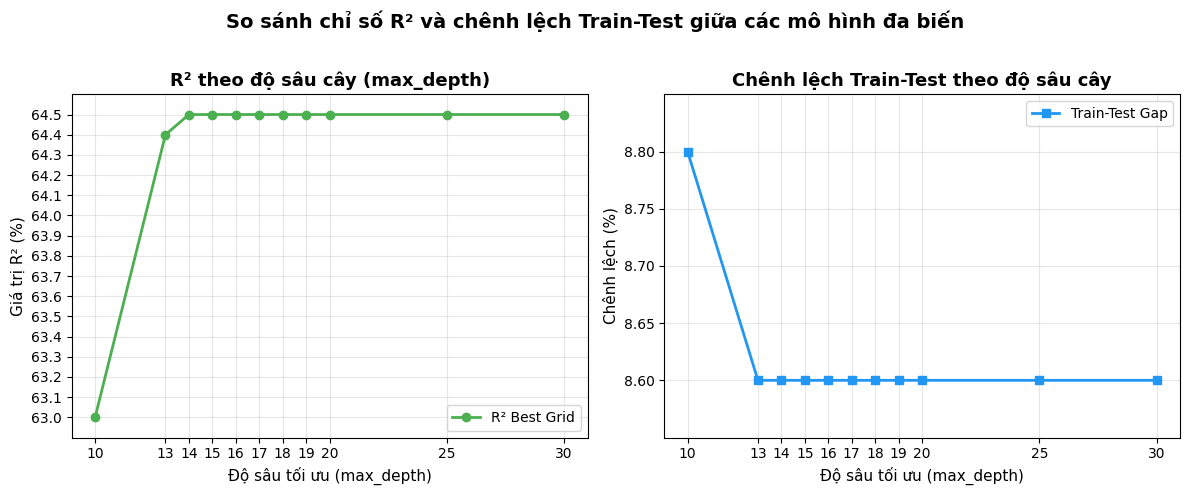

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# --- Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# --- Biểu đồ 1: R² ---
axes[0].plot(df2['max_depth'], df2['R² tối ưu (Best Grid)'],
             marker='o', color='#4CAF50', linewidth=2, label='R² Best Grid')
axes[0].set_title('R² theo độ sâu cây (max_depth)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Độ sâu tối ưu (max_depth)', fontsize=11)
axes[0].set_ylabel('Giá trị R² (%)', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].legend()

y_min, y_max = df2['R² tối ưu (Best Grid)'].min(), df2['R² tối ưu (Best Grid)'].max()
axes[0].set_ylim(y_min - 0.1, y_max + 0.1)
axes[0].set_yticks(np.arange(np.floor(y_min*10)/10, np.ceil(y_max*10)/10 + 0.1, 0.1))

axes[1].plot(df2['max_depth'], df2['Chênh lệch train-test'],
             marker='s', color='#2196F3', linewidth=2, label='Train-Test Gap')
axes[1].set_title('Chênh lệch Train-Test theo độ sâu cây', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Độ sâu tối ưu (max_depth)', fontsize=11)
axes[1].set_ylabel('Chênh lệch (%)', fontsize=11)
axes[0].set_xticks(df2['max_depth'])
axes[1].grid(alpha=0.3)
axes[1].legend()

y_min2, y_max2 = df2['Chênh lệch train-test'].min(), df2['Chênh lệch train-test'].max()
axes[1].set_ylim(y_min2 - 0.05, y_max2 + 0.05)
axes[1].set_yticks(np.linspace(y_min2, y_max2, 5))
axes[1].set_xticks(df2['max_depth'])

plt.suptitle('So sánh chỉ số R² và chênh lệch Train-Test giữa các mô hình đa biến',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### ID3 - C4.5 - CART COMPARISON

#### Training on CART best parameters

In [ ]:

def regression_eval(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

# 1. CART (MSE)
cart_reg = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=4,
    max_features=None,
    max_leaf_nodes=170,
    ccp_alpha=0,
    random_state=42
)
cart_reg.fit(X_train, y_train)
cart_pred = cart_reg.predict(X_test)
cart_mae, cart_mse, cart_r2 = regression_eval(y_test, cart_pred)

# 2. ID3 (Information Gain)
id3_reg = DecisionTreeRegressor(
    criterion='absolute_error',
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=4,
    max_features=None,
    max_leaf_nodes=170,
    # ccp_alpha=0,
    random_state=42
)
id3_reg.fit(X_train, y_train)
id3_pred = id3_reg.predict(X_test)
id3_mae, id3_mse, id3_r2 = regression_eval(y_test, id3_pred)

# 3. C4.5 (Gain Ratio)
c45_reg = DecisionTreeRegressor(
    criterion='poisson',
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=4,
    max_features=None,
    max_leaf_nodes=170,
    ccp_alpha=0,
    random_state=42
)
c45_reg.fit(X_train, y_train)
c45_pred = c45_reg.predict(X_test)
c45_mae, c45_mse, c45_r2 = regression_eval(y_test, c45_pred)

# 4. Results
print("CART:  MAE = %.4f | MSE = %.4f | R² = %.4f" % (cart_mae, cart_mse, cart_r2))
print("ID3:   MAE = %.4f | MSE = %.4f | R² = %.4f" % (id3_mae, id3_mse, id3_r2))
print("C4.5:  MAE = %.4f | MSE = %.4f | R² = %.4f" % (c45_mae, c45_mse, c45_r2))


CART:  MAE = 0.0986 | MSE = 0.0165 | R² = 0.6455
ID3:   MAE = 0.1026 | MSE = 0.0192 | R² = 0.5865
C4.5:  MAE = 0.1000 | MSE = 0.0170 | R² = 0.6350


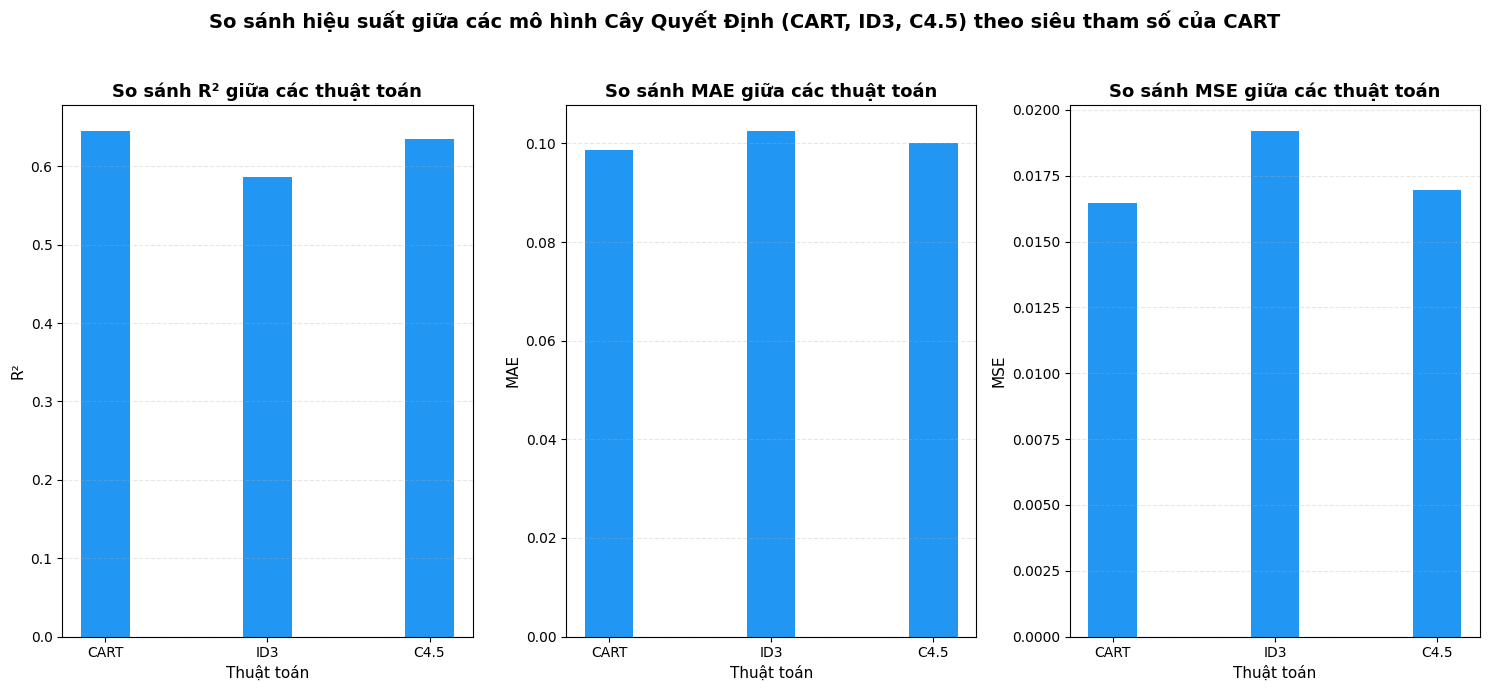

In [160]:
results = {
    'Thuật toán': ['CART', 'ID3', 'C4.5'],
    'R²': [cart_r2, id3_r2, c45_r2],
    'MAE': [cart_mae, id3_mae, c45_mae],
    'MSE': [cart_mse, id3_mse, c45_mse]
}
df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
metrics = ['R²', 'MAE', 'MSE']

for i, metric in enumerate(metrics):
    axes[i].bar(df['Thuật toán'], df[metric], color='#2196F3', width=0.3)
    axes[i].set_title(f'So sánh {metric} giữa các thuật toán', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Thuật toán', fontsize=11)
    axes[i].set_ylabel(metric, fontsize=11)
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle('So sánh hiệu suất giữa các mô hình Cây Quyết Định (CART, ID3, C4.5) theo siêu tham số của CART',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Chạy 3 mô hình với tham số mặc định

In [161]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. CART (MSE)
cart_reg = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=42
)
cart_reg.fit(X_train, y_train)
cart_pred = cart_reg.predict(X_test)
cart_mae, cart_mse, cart_r2 = regression_eval(y_test, cart_pred)

# 2. ID3 (Information Gain)
id3_reg = DecisionTreeRegressor(
    criterion='absolute_error',
    random_state=42
)
id3_reg.fit(X_train, y_train)
id3_pred = id3_reg.predict(X_test)
id3_mae, id3_mse, id3_r2 = regression_eval(y_test, id3_pred)

# 3. C4.5 (Gain Ratio)
c45_reg = DecisionTreeRegressor(
    criterion='poisson',
    random_state=42
)
c45_reg.fit(X_train, y_train)
c45_pred = c45_reg.predict(X_test)
c45_mae, c45_mse, c45_r2 = regression_eval(y_test, c45_pred)

print("CART:  MAE = %.4f | MSE = %.4f | R² = %.4f" % (cart_mae, cart_mse, cart_r2))
print("ID3:   MAE = %.4f | MSE = %.4f | R² = %.4f" % (id3_mae, id3_mse, id3_r2))
print("C4.5:  MAE = %.4f | MSE = %.4f | R² = %.4f" % (c45_mae, c45_mse, c45_r2))


CART:  MAE = 0.0632 | MSE = 0.0139 | R² = 0.7009
ID3:   MAE = 0.0637 | MSE = 0.0141 | R² = 0.6961
C4.5:  MAE = 0.0646 | MSE = 0.0146 | R² = 0.6866


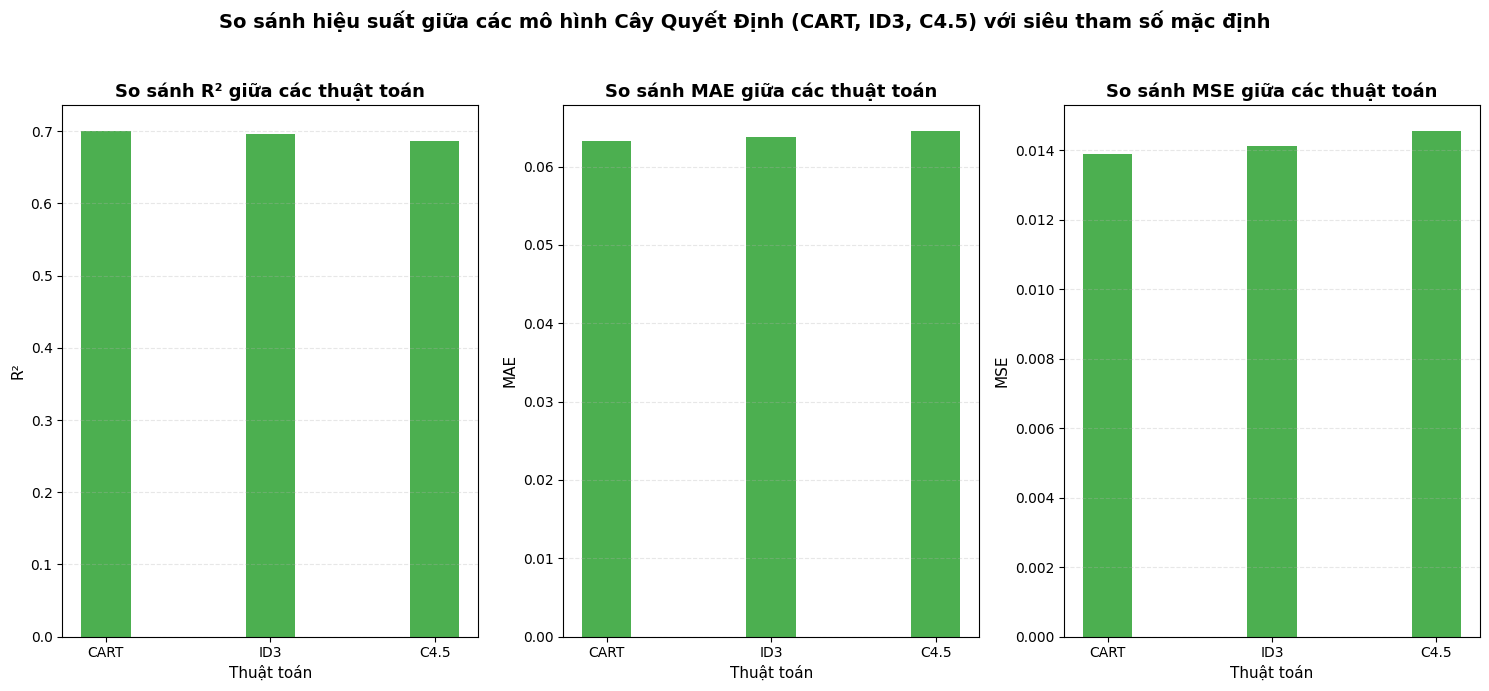

In [162]:
results = {
    'Thuật toán': ['CART', 'ID3', 'C4.5'],
    'R²': [cart_r2, id3_r2, c45_r2],
    'MAE': [cart_mae, id3_mae, c45_mae],
    'MSE': [cart_mse, id3_mse, c45_mse]
}
df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
metrics = ['R²', 'MAE', 'MSE']

for i, metric in enumerate(metrics):
    axes[i].bar(df['Thuật toán'], df[metric], color = '#4CAF50', width=0.3)
    axes[i].set_title(f'So sánh {metric} giữa các thuật toán', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Thuật toán', fontsize=11)
    axes[i].set_ylabel(metric, fontsize=11)
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle('So sánh hiệu suất giữa các mô hình Cây Quyết Định (CART, ID3, C4.5) với siêu tham số mặc định',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()